# RSS Feeds Exploration

This notebook explores RSS feeds as a data source for tech news. We'll:

- Load RSS feed configuration from JSON
- Collect articles from multiple tech RSS feeds
- Parse and clean the data
- Filter articles from the last 24 hours
- Save organized data in JSON format
- Analyze feed performance and content quality

## Setup


In [1]:
import sys
import os
import json
import feedparser
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List, Dict, Optional
import time
import re
from tqdm import tqdm

# Load RSS feed configuration
with open('../config/rss_feeds.json', 'r') as f:
    rss_config = json.load(f)

print("✅ RSS feed configuration loaded")
print(f"📊 Total feeds configured: {len(rss_config['feeds'])}")
print(f"⚙️ Settings: {rss_config['settings']}")

# Display enabled feeds
enabled_feeds = [feed for feed in rss_config['feeds'] if feed['enabled']]
print(f"\n📰 Enabled feeds ({len(enabled_feeds)}):")
for feed in enabled_feeds:
    print(f"  • {feed['name']} ({feed['category']})")


✅ RSS feed configuration loaded
📊 Total feeds configured: 39
⚙️ Settings: {'max_age_hours': 24, 'max_items_per_feed': 30, 'timeout_seconds': 30, 'retry_attempts': 3}

📰 Enabled feeds (39):
  • Google The Keyword (company_blog)
  • Google Research (research)
  • Microsoft Official Blog (company_blog)
  • Microsoft Developer Blog (development)
  • Azure Blog (cloud)
  • Amazon AWS News (cloud)
  • OpenAI (ai)
  • Meta Engineering (company_blog)
  • Dropbox Tech Blog (company_blog)
  • GitHub Engineering (development)
  • Cloudflare Blog (infrastructure)
  • Stripe Blog (fintech)
  • Mozilla Blog (company_blog)
  • Kubernetes Blog (infrastructure)
  • JetBrains Blog (development)
  • Slack Engineering (company_blog)
  • LinkedIn Engineering (company_blog)
  • Pinterest Engineering (company_blog)
  • Airbnb Engineering (company_blog)
  • Ars Technica (tech_news)
  • TechCrunch (tech_news)
  • The Verge (tech_news)
  • Engadget (tech_news)
  • ZDNet (tech_news)
  • The Register (tech_news)


## RSS Feed Collector Class


In [2]:
class RSSFeedCollector:
    def __init__(self, config):
        self.config = config
        self.settings = config['settings']
        self.feeds = [feed for feed in config['feeds'] if feed['enabled']]
        
    def clean_text(self, text):
        """Clean and normalize text content"""
        if not text:
            return ""
        
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        # Strip leading/trailing whitespace
        return text.strip()
    
    def parse_article(self, entry, feed_info):
        """Parse a single RSS entry into standardized format"""
        try:
            # Handle different date formats
            published_date = None
            if hasattr(entry, 'published_parsed') and entry.published_parsed:
                published_date = datetime(*entry.published_parsed[:6])
            elif hasattr(entry, 'updated_parsed') and entry.updated_parsed:
                published_date = datetime(*entry.updated_parsed[:6])
            
            # Clean content
            title = self.clean_text(entry.get('title', ''))
            summary = self.clean_text(entry.get('summary', ''))
            description = self.clean_text(entry.get('description', ''))
            
            # Use description if summary is empty
            if not summary and description:
                summary = description
            
            article = {
                'title': title,
                'url': entry.get('link', ''),
                'summary': summary,
                'content': self.clean_text(entry.get('content', [{}])[0].get('value', '')),
                'published': published_date.isoformat() if published_date else None,
                'author': entry.get('author', ''),
                'feed_name': feed_info['name'],
                'feed_category': feed_info['category'],
                'feed_url': feed_info['url'],
                'tags': [tag.term for tag in entry.get('tags', [])],
                'guid': entry.get('id', entry.get('guid', '')),
                'raw_entry': {
                    'title': entry.get('title', ''),
                    'summary': entry.get('summary', ''),
                    'link': entry.get('link', ''),
                    'published': entry.get('published', ''),
                    'author': entry.get('author', '')
                }
            }
            
            return article
            
        except Exception as e:
            print(f"Error parsing article: {e}")
            return None
    
    def fetch_feed(self, feed_info):
        """Fetch and parse a single RSS feed"""
        try:
            # Parse the RSS feed
            feed = feedparser.parse(feed_info['url'])
            
            if feed.bozo:
                tqdm.write(f"⚠️ Warning: {feed_info['name']} has parsing issues")
            
            articles = []
            cutoff_time = datetime.now() - timedelta(hours=self.settings['max_age_hours'])
            
            for entry in feed.entries[:self.settings['max_items_per_feed']]:
                article = self.parse_article(entry, feed_info)
                if article:
                    # Filter by age
                    if article['published']:
                        article_date = datetime.fromisoformat(article['published'].replace('Z', '+00:00'))
                        if article_date >= cutoff_time:
                            articles.append(article)
                    else:
                        # If no date, include it (might be recent)
                        articles.append(article)
            
            # Use tqdm.write to avoid interfering with progress bar
            tqdm.write(f"✅ {feed_info['name']}: {len(articles)} articles")
            return articles
            
        except Exception as e:
            tqdm.write(f"❌ Error fetching {feed_info['name']}: {e}")
            return []
    
    def collect_all_feeds(self):
        """Collect articles from all enabled feeds"""
        all_articles = []
        feed_stats = []
        
        # Use tqdm for progress tracking
        for feed in tqdm(self.feeds, desc="Fetching RSS feeds", unit="feed"):
            articles = self.fetch_feed(feed)
            all_articles.extend(articles)
            
            feed_stats.append({
                'feed_name': feed['name'],
                'category': feed['category'],
                'articles_count': len(articles),
                'url': feed['url']
            })
            
            # Minimal delay to be respectful to servers
            time.sleep(0.1)  # 100ms delay
        
        return all_articles, feed_stats


## Collect RSS Data


In [3]:
# Initialize collector
collector = RSSFeedCollector(rss_config)

# Collect articles from all feeds
print("🚀 Starting RSS feed collection...")
print(f"⏰ Collecting articles from last {rss_config['settings']['max_age_hours']} hours")
print("=" * 60)

all_articles, feed_stats = collector.collect_all_feeds()

print("=" * 60)
print(f"✅ Collection complete!")
print(f"📊 Total articles collected: {len(all_articles)}")
print(f"📰 Feeds processed: {len(feed_stats)}")

# Display feed statistics
print(f"\n📈 Feed Statistics:")
for stat in feed_stats:
    print(f"  • {stat['feed_name']}: {stat['articles_count']} articles")


🚀 Starting RSS feed collection...
⏰ Collecting articles from last 24 hours


Fetching RSS feeds:   3%|▎         | 1/39 [00:00<00:14,  2.61feed/s]

✅ Google The Keyword: 9 articles


Fetching RSS feeds:   5%|▌         | 2/39 [00:00<00:17,  2.13feed/s]

✅ Google Research: 1 articles


Fetching RSS feeds:   8%|▊         | 3/39 [00:01<00:14,  2.47feed/s]

✅ Microsoft Official Blog: 0 articles


Fetching RSS feeds:  10%|█         | 4/39 [00:01<00:14,  2.40feed/s]

✅ Microsoft Developer Blog: 0 articles


Fetching RSS feeds:  13%|█▎        | 5/39 [00:02<00:15,  2.21feed/s]

✅ Azure Blog: 0 articles


Fetching RSS feeds:  15%|█▌        | 6/39 [00:02<00:15,  2.17feed/s]

✅ Amazon AWS News: 2 articles


Fetching RSS feeds:  18%|█▊        | 7/39 [00:03<00:14,  2.15feed/s]

✅ OpenAI: 0 articles


Fetching RSS feeds:  21%|██        | 8/39 [00:03<00:11,  2.62feed/s]

✅ Meta Engineering: 0 articles


Fetching RSS feeds:  23%|██▎       | 9/39 [00:04<00:18,  1.59feed/s]

✅ Dropbox Tech Blog: 0 articles


Fetching RSS feeds:  26%|██▌       | 10/39 [00:04<00:14,  1.94feed/s]

✅ GitHub Engineering: 0 articles


Fetching RSS feeds:  28%|██▊       | 11/39 [00:05<00:16,  1.74feed/s]

✅ Cloudflare Blog: 1 articles


Fetching RSS feeds:  31%|███       | 12/39 [00:05<00:13,  1.94feed/s]

✅ Stripe Blog: 0 articles


Fetching RSS feeds:  33%|███▎      | 13/39 [00:06<00:12,  2.11feed/s]

✅ Mozilla Blog: 0 articles


Fetching RSS feeds:  36%|███▌      | 14/39 [00:06<00:12,  2.06feed/s]

✅ Kubernetes Blog: 1 articles


Fetching RSS feeds:  38%|███▊      | 15/39 [00:06<00:09,  2.45feed/s]

✅ JetBrains Blog: 3 articles


Fetching RSS feeds:  41%|████      | 16/39 [00:07<00:08,  2.87feed/s]

✅ Slack Engineering: 0 articles


Fetching RSS feeds:  44%|████▎     | 17/39 [00:07<00:06,  3.16feed/s]

✅ LinkedIn Engineering: 0 articles


Fetching RSS feeds:  46%|████▌     | 18/39 [00:07<00:06,  3.09feed/s]

✅ Pinterest Engineering: 0 articles


Fetching RSS feeds:  49%|████▊     | 19/39 [00:08<00:07,  2.66feed/s]

✅ Airbnb Engineering: 0 articles


Fetching RSS feeds:  51%|█████▏    | 20/39 [00:08<00:07,  2.70feed/s]

✅ Ars Technica: 20 articles


Fetching RSS feeds:  54%|█████▍    | 21/39 [00:09<00:08,  2.24feed/s]

✅ TechCrunch: 0 articles


Fetching RSS feeds:  56%|█████▋    | 22/39 [00:09<00:06,  2.60feed/s]

✅ The Verge: 10 articles


Fetching RSS feeds:  59%|█████▉    | 23/39 [00:10<00:08,  2.00feed/s]

⚠️ Warning: Engadget has parsing issues
✅ Engadget: 30 articles


Fetching RSS feeds:  62%|██████▏   | 24/39 [00:10<00:06,  2.41feed/s]

✅ ZDNet: 20 articles


Fetching RSS feeds:  64%|██████▍   | 25/39 [00:10<00:05,  2.75feed/s]

✅ The Register: 27 articles


Fetching RSS feeds:  67%|██████▋   | 26/39 [00:11<00:04,  2.65feed/s]

✅ InfoQ: 3 articles


Fetching RSS feeds:  69%|██████▉   | 27/39 [00:11<00:04,  2.79feed/s]

✅ TechRepublic: 4 articles


Fetching RSS feeds:  72%|███████▏  | 28/39 [00:13<00:09,  1.11feed/s]

✅ Interesting Engineering: 10 articles


Fetching RSS feeds:  74%|███████▍  | 29/39 [00:13<00:07,  1.36feed/s]

✅ arXiv AI: 30 articles


Fetching RSS feeds:  77%|███████▋  | 30/39 [00:14<00:05,  1.57feed/s]

✅ arXiv Machine Learning: 30 articles


Fetching RSS feeds:  79%|███████▉  | 31/39 [00:14<00:04,  1.87feed/s]

✅ Hacker News Front Page: 19 articles


Fetching RSS feeds:  82%|████████▏ | 32/39 [00:15<00:03,  2.16feed/s]

✅ Hacker News Newest: 20 articles
✅ GitHub Changelog: 5 articles


Fetching RSS feeds:  87%|████████▋ | 34/39 [00:15<00:01,  2.72feed/s]

✅ Docker Blog: 4 articles


Fetching RSS feeds:  90%|████████▉ | 35/39 [00:15<00:01,  2.82feed/s]

✅ Kaggle Blog: 0 articles


Fetching RSS feeds:  92%|█████████▏| 36/39 [00:16<00:00,  3.08feed/s]

✅ Percona Database Blog: 0 articles


Fetching RSS feeds:  95%|█████████▍| 37/39 [00:16<00:00,  3.24feed/s]

✅ Elastic Blog: 2 articles
✅ NYT Technology: 7 articles


Fetching RSS feeds: 100%|██████████| 39/39 [00:16<00:00,  2.33feed/s]

✅ BBC Technology: 4 articles
✅ Collection complete!
📊 Total articles collected: 262
📰 Feeds processed: 39

📈 Feed Statistics:
  • Google The Keyword: 9 articles
  • Google Research: 1 articles
  • Microsoft Official Blog: 0 articles
  • Microsoft Developer Blog: 0 articles
  • Azure Blog: 0 articles
  • Amazon AWS News: 2 articles
  • OpenAI: 0 articles
  • Meta Engineering: 0 articles
  • Dropbox Tech Blog: 0 articles
  • GitHub Engineering: 0 articles
  • Cloudflare Blog: 1 articles
  • Stripe Blog: 0 articles
  • Mozilla Blog: 0 articles
  • Kubernetes Blog: 1 articles
  • JetBrains Blog: 3 articles
  • Slack Engineering: 0 articles
  • LinkedIn Engineering: 0 articles
  • Pinterest Engineering: 0 articles
  • Airbnb Engineering: 0 articles
  • Ars Technica: 20 articles
  • TechCrunch: 0 articles
  • The Verge: 10 articles
  • Engadget: 30 articles
  • ZDNet: 20 articles
  • The Register: 27 articles
  • InfoQ: 3 articles
  • TechRepublic: 4 articles
  • Interesting Engineering: 10 

## Analyze and Save Data


In [4]:
# Create data directory
os.makedirs('../data/rss', exist_ok=True)

# Convert to DataFrame for analysis
df = pd.DataFrame(all_articles)

if len(df) > 0:
    print(f"📊 Data Analysis:")
    print(f"   Total articles: {len(df)}")
    print(f"   Unique feeds: {df['feed_name'].nunique()}")
    print(f"   Categories: {df['feed_category'].unique().tolist()}")
    print(f"   Date range: {df['published'].min()} to {df['published'].max()}")
    
    # Articles by category
    category_counts = df['feed_category'].value_counts()
    print(f"\n📈 Articles by Category:")
    for category, count in category_counts.items():
        print(f"   {category}: {count} articles")
    
    # Articles by feed
    feed_counts = df['feed_name'].value_counts()
    print(f"\n📰 Articles by Feed:")
    for feed, count in feed_counts.head(10).items():
        print(f"   {feed}: {count} articles")
    
    # Save all articles
    all_articles_path = '../data/rss/rss_articles.json'
    df.to_json(all_articles_path, orient='records', indent=2)
    print(f"\n💾 Saved all articles to {all_articles_path}")
    
    # Save by category
    for category in df['feed_category'].unique():
        category_df = df[df['feed_category'] == category]
        category_path = f'../data/rss/rss_{category}.json'
        category_df.to_json(category_path, orient='records', indent=2)
        print(f"💾 Saved {category} articles to {category_path}")
    
    # Save by feed
    for feed_name in df['feed_name'].unique():
        feed_df = df[df['feed_name'] == feed_name]
        feed_safe_name = feed_name.lower().replace(' ', '_').replace('/', '_')
        feed_path = f'../data/rss/rss_{feed_safe_name}.json'
        feed_df.to_json(feed_path, orient='records', indent=2)
    
    # Save collection summary
    summary_data = {
        'collection_date': datetime.now().isoformat(),
        'total_articles': len(df),
        'feeds_processed': len(feed_stats),
        'categories': category_counts.to_dict(),
        'feed_stats': feed_stats,
        'settings': rss_config['settings'],
        'data_structure': {
            'fields': list(df.columns),
            'format': 'JSON',
            'encoding': 'UTF-8'
        }
    }
    
    summary_path = '../data/rss/collection_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=2)
    
    print(f"💾 Saved collection summary to {summary_path}")
    
else:
    print("❌ No articles collected")


📊 Data Analysis:
   Total articles: 262
   Unique feeds: 23
   Categories: ['company_blog', 'research', 'cloud', 'infrastructure', 'development', 'tech_news']
   Date range: 2025-09-18T15:36:53 to 2025-09-19T19:09:48

📈 Articles by Category:
   tech_news: 132 articles
   research: 61 articles
   development: 50 articles
   company_blog: 9 articles
   infrastructure: 8 articles
   cloud: 2 articles

📰 Articles by Feed:
   arXiv AI: 30 articles
   Engadget: 30 articles
   arXiv Machine Learning: 30 articles
   The Register: 27 articles
   Hacker News Newest: 20 articles
   Ars Technica: 20 articles
   ZDNet: 20 articles
   Hacker News Front Page: 19 articles
   The Verge: 10 articles
   Interesting Engineering: 10 articles

💾 Saved all articles to ../data/rss/rss_articles.json
💾 Saved company_blog articles to ../data/rss/rss_company_blog.json
💾 Saved research articles to ../data/rss/rss_research.json
💾 Saved cloud articles to ../data/rss/rss_cloud.json
💾 Saved infrastructure articles to 

## Visualize Data


💾 Saved analysis plot to ../data/rss/rss_analysis.png


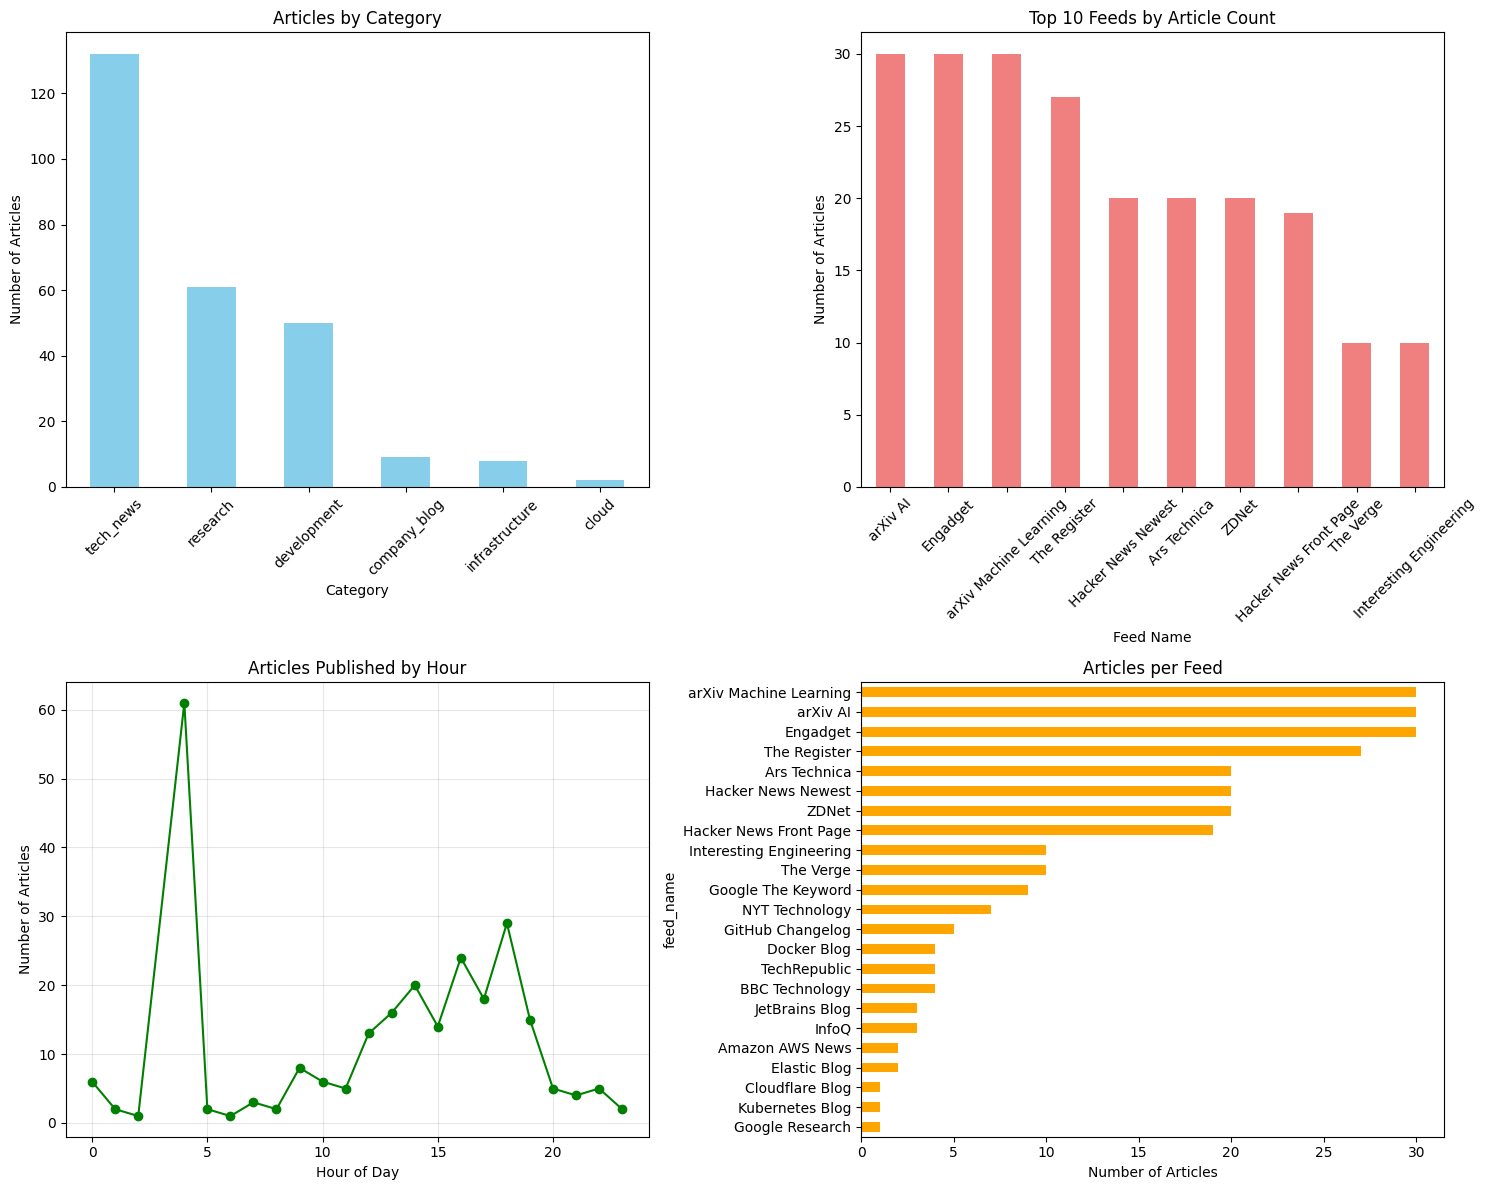


📰 Sample Articles:

1. Find out what’s new in the Gemini app in September’s Gemini Drop.
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T16:00:00
   Summary: Gemini Drops is our new monthly update on how to get the most out of the Gemini app....
   URL: https://blog.google/products/gemini/gemini-drop-september-2025/

2. 3 ways to use photo-to-video in Gemini
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T16:00:00
   Summary: A collage of images including a still photo of a dinosaur skeleton, then the animated version create...
   URL: https://blog.google/products/gemini/gemini-photo-to-video-tips/

3. How the U.S. Patent and Trademark Office can help America maintain its AI leadership
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T13:30:00
   Summary: Stylized US map with connected dots, lightbulb, three bars, three toggle switches, orange block with...
   URL: https://blog.google/outreach-initiatives/public-policy/uspto-ai

In [5]:
if len(df) > 0:
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Articles by Category
    category_counts.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Articles by Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Number of Articles')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Top 10 Feeds
    feed_counts.head(10).plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Top 10 Feeds by Article Count')
    ax2.set_xlabel('Feed Name')
    ax2.set_ylabel('Number of Articles')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Articles by Hour (if we have time data)
    if 'published' in df.columns and df['published'].notna().any():
        df['published_dt'] = pd.to_datetime(df['published'])
        df['hour'] = df['published_dt'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        hourly_counts.plot(kind='line', ax=ax3, marker='o', color='green')
        ax3.set_title('Articles Published by Hour')
        ax3.set_xlabel('Hour of Day')
        ax3.set_ylabel('Number of Articles')
        ax3.grid(True, alpha=0.3)
    
    # 4. Feed Performance (articles per feed)
    feed_performance = df.groupby('feed_name').size().sort_values(ascending=True)
    feed_performance.plot(kind='barh', ax=ax4, color='orange')
    ax4.set_title('Articles per Feed')
    ax4.set_xlabel('Number of Articles')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('../data/rss/rss_analysis.png', dpi=300, bbox_inches='tight')
    print("💾 Saved analysis plot to ../data/rss/rss_analysis.png")
    
    plt.show()
    
    # Display sample articles
    print(f"\n📰 Sample Articles:")
    for i, (_, article) in enumerate(df.head(3).iterrows(), 1):
        print(f"\n{i}. {article['title']}")
        print(f"   Feed: {article['feed_name']} ({article['feed_category']})")
        print(f"   Published: {article['published']}")
        print(f"   Summary: {article['summary'][:100]}...")
        print(f"   URL: {article['url']}")
else:
    print("❌ No data to visualize")
